# Heterogeneous medium

In [1]:
# ! pip install git+https://github.com/ivanmkc/jwave.git@experimental k-wave-python

In [2]:
# ! pip install jwave
# ! pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install "jaxlib[cuda]"

In [3]:
# %load_ext line_profiler

In [4]:
# ! which python

In [ ]:
import numpy as np

from jax import jit
from jax import numpy as jnp
from jaxdf import FourierSeries
from matplotlib import pyplot as plt

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *
from jwave.geometry import circ_mask
from jwave.utils import show_field, show_positive_field

domain = Domain((320, 320), (50e-3/220, 50e-3/220))
# domain = Domain((256, 256), (50e-3, 50e-3))
pml_size = 30

In [ ]:
print("Grid dimensions in meters")
print(np.array(domain.N) * np.array(domain.dx))

In [ ]:
print("Grid dimensions in inches")
m_to_inches = 39.3701
print(m_to_inches* np.array(domain.N) * np.array(domain.dx))

# Define the medium

In [8]:
sound_speed_background = 800  # Background sound speed [m/s]
density_background = 1000  # Background density [kg/m^3]

sound_speed_map=sound_speed_background * np.ones(domain.N)
density_map=density_background * np.ones(domain.N)

# Define a random distribution of scatterers for the medium
background_map_mean = 0
background_map_std = 15
sound_speed_map += background_map_std * np.random.randn(domain.N[0], domain.N[1])
density_map += background_map_std * np.random.randn(domain.N[0], domain.N[1])

In [9]:
max_freq = sound_speed_background/(2*np.min(domain.dx))

max_freq

1760000.0

In [10]:
medium = Medium(domain=domain, sound_speed=sound_speed_background, density=density_map, pml_size=pml_size)
time_axis = TimeAxis.from_medium(medium, cfl=0.3)
# time_axis = TimeAxis.from_medium(medium, cfl=0.2, t_end=time_axis.t_end*3)

In [11]:
import numpy as np

# Layer properties
layer_thicknesses = np.array([0.03, 0.02, 0.04])  # e.g., Drywall, Wood, Insulation, Air Gap, Drywall

# Define the sound speed and density values for each layer according to common building materials
layer_sound_speeds = [1500, 3300, sound_speed_background]  # Sound speed values for Drywall, Wood, Insulation, Air Gap, Background
layer_densities = [800, 600, density_background]  # Density values for Drywall, Wood, Insulation, Air Gap, Background

# Get the dimensions of the kgrid
Nx, Ny = domain.N

# # Set each layer separately in a for loop
# end_index = Ny
# for i, thickness in enumerate(layer_thicknesses[::-1]):  # Reverse the order of layers
#     start_index = end_index - int(thickness / domain.dx[1])
#     print(f"start_index = {start_index}, end_index = {end_index}")
#     # Reverse the order of sound speeds and densities for proper layering
#     sound_speed_map[:, start_index:end_index] = layer_sound_speeds[::-1][i]
#     density_map[:, start_index:end_index] = layer_densities[::-1][i]
#     end_index = start_index

In [12]:
from jwave.geometry import circ_mask

circle_mask = np.zeros(domain.N)

circle_center = np.array(domain.N)*np.array([3/4, 3/4])

circle_mask += circ_mask(domain.N, 20, np.array(domain.N)/np.array([4, 2.5]))
# circle_mask += circ_mask(domain.N, 10, circle_center)
# circle_mask += circ_mask(domain.N, 10, np.array(domain.N)/np.array([2, 3]))
# circle_mask += circ_mask(domain.N, 10, np .array(domain.N)/np.array([4, 4]))
circle_mask += circ_mask(domain.N, 10, np.array(domain.N)*np.array([3.4/4, 3/5]))
# circle_mask += circ_mask(domain.N, 10, np.array(domain.N)*np.array([3/4, 1/5]))
circle_mask = circle_mask.astype(bool)

# sound_speed_map[circle_mask] = 250
# density_map[circle_mask] = 700

# Define a random distribution of scatterers for the medium
# background_map_mean = 0
# background_map_std = 25
# sound_speed_map += circle_mask * background_map_std * np.random.randn(domain.N[0], domain.N[1])
# density_map += circle_mask * background_map_std * np.random.randn(domain.N[0], domain.N[1])

scattering_map = np.random.randn(domain.N[0], domain.N[1])
scattering_c0 = np.clip(1540 + 25 + 75 * scattering_map, 1400, 1600)
scattering_rho0 = scattering_c0 / 1.5

sound_speed_map[circle_mask] = scattering_c0[circle_mask]
density_map[circle_mask] = scattering_rho0[circle_mask]

In [13]:
# np.histogram(scattering_c0.flatten())

In [14]:
DOMAIN_EDGE_OFFSET = pml_size

print(f"y = {domain.N[1]-DOMAIN_EDGE_OFFSET}")

y = 290


In [15]:
sound_speed_map[:, domain.N[1]-DOMAIN_EDGE_OFFSET:domain.N[1]] = 2000
density_map[:, domain.N[1]-DOMAIN_EDGE_OFFSET:domain.N[1]] = 700

# sound_speed_map[domain.N[0]//2 - 50:domain.N[0]//2 - 10, domain.N[1]//2 - 30:domain.N[1]//2 - 10] = 2000
# density_map[domain.N[0]//2 - 50:domain.N[0]//2 - 10, domain.N[1]//2 - 30:domain.N[1]//2 - 10] = 700

# sound_speed_map[domain.N[0]//2:domain.N[0]//2 + 50, domain.N[1]//2:domain.N[1]//2 + 30] = 2000
# density_map[domain.N[0]//2:domain.N[0]//2 + 50, domain.N[1]//2:domain.N[1]//2 + 30] = 700

## Visualize medium

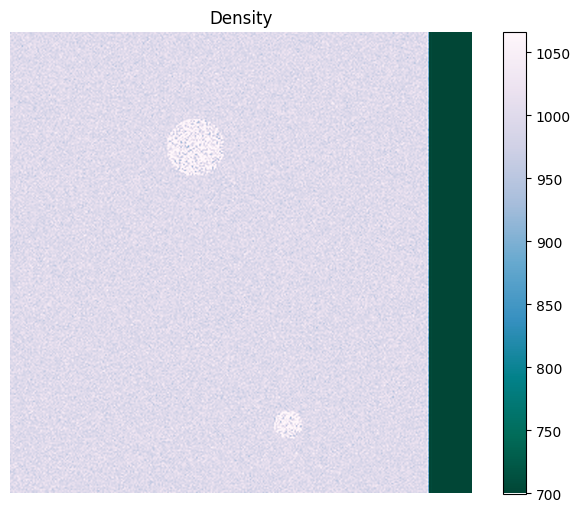

In [16]:
show_positive_field(density_map, aspect=None)
_ = plt.title("Density")

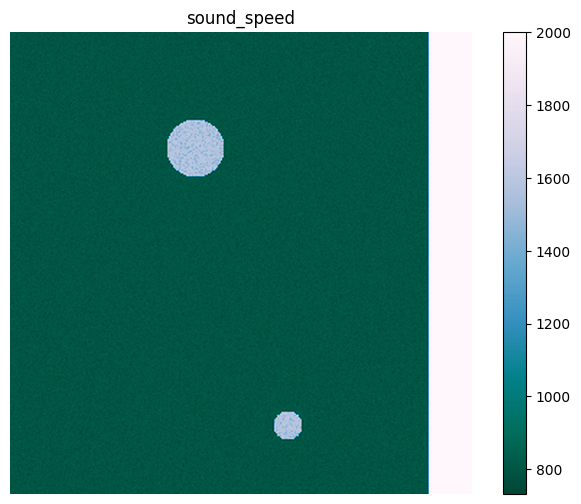

In [17]:
show_positive_field(sound_speed_map, aspect=None)
_ = plt.title("sound_speed")

# Signal source

In [18]:
from kwave.utils.signals import tone_burst

# Define the acoustic source
source_frequency = 1e5  # Source frequency [Hz]
source_amplitude = 1 # Source amplitude [Pa]
source_num_cycles = 3  # Number of cycles in the source tone burst

source_signal = jnp.squeeze(source_amplitude * tone_burst(1 / time_axis.dt, source_frequency, source_num_cycles))  # Create the source signal

assert source_frequency <= max_freq

source_signal.shape

(353,)

In [19]:
t = jnp.arange(0, time_axis.t_end, time_axis.dt)

pad_width = t.shape[0] - len(source_signal)
padded_signal = jnp.pad(source_signal, (0, pad_width), mode='constant')

padded_signal.shape

(1504,)

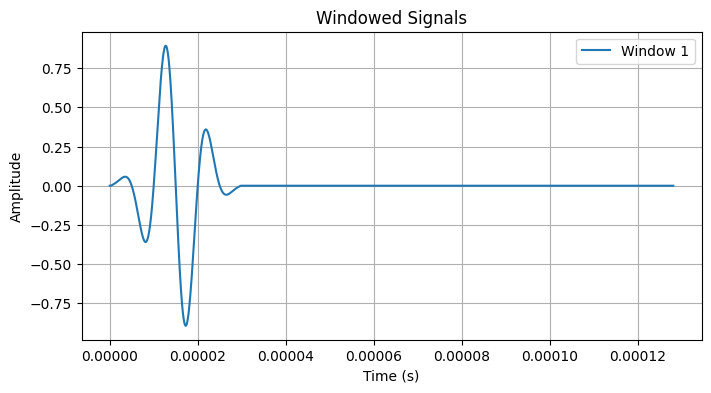

In [20]:
# Plot padded signal
from jwave.signal_processing import gaussian_window
import jax.numpy as jnp
import matplotlib.pyplot as plt

# t = jnp.arange(0, time_axis.t_end, time_axis.dt)
# frequency = 1e6  # Decreased frequency

# s = 200 * jnp.sin(2 * jnp.pi * frequency * t)  # Increased amplitude

s1 = padded_signal
# s2 = gaussian_window(signal=s, time=t, mu=6e-6, sigma=1e-5)  # Adjusted window parameters

plt.figure(figsize=(8, 4))
plt.plot(t, s1, label='Window 1')
# plt.plot(t, s2, label='Window 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Windowed Signals')
plt.legend()
plt.grid(True)
plt.show()

# Plot pressure field

Create a point signal source (using above signal) and simulate the pressure field.
Since `simulate_wave_propagation` has no sensors passed to it, it will return the entire pressure field as if sensors were placed everywhere in the domain.

In [21]:
from jwave.geometry import Sources

sources = Sources(
    # positions=([domain.N[0]//2], [domain.N[1]//6]),
    positions=([domain.N[0] // 2], [25]),
    signals=jnp.stack([s1]),
    dt=time_axis.dt,
    domain=domain,
)

In [22]:
import jaxdf
from typing import Any, Optional

@jit
def compiled_simulator(
    domain: jaxdf.geometry.Domain,
    sound_speed_field,
    density_field, 
    initial_pressure,
    sources=None
):
    medium = Medium(domain=domain, sound_speed=sound_speed_field, density=density_field, pml_size=pml_size)
    return simulate_wave_propagation(
        medium, 
        time_axis, 
        p0=initial_pressure, 
        sources=sources)

In [23]:
pressure_combined_raw = compiled_simulator(domain=domain,
                                           sound_speed_field=sound_speed_map,
                                           density_field=density_map,
                                           initial_pressure=None,
                                           sources=sources).on_grid

## Plot pressure field at final time 

Text(0.5, 1.0, 'Pressure field at t=0.00012809658073820174')

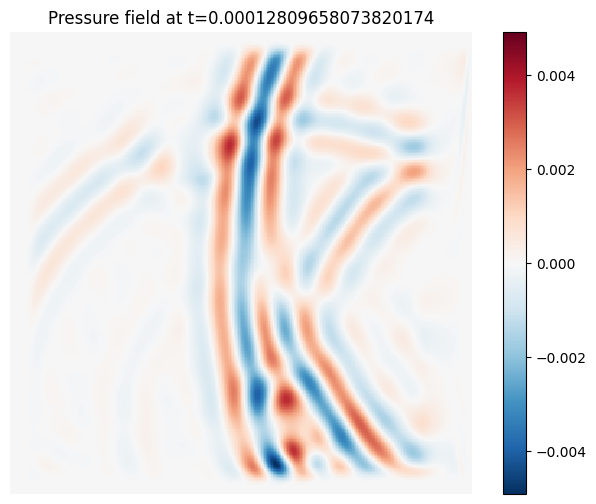

In [24]:
t = -1
show_field(pressure_combined_raw[t], aspect=None)
plt.title(f"Pressure field at t={time_axis.to_array()[t]}")

## Plot and Video

Plot a time lapse and generate a video of the pressure field

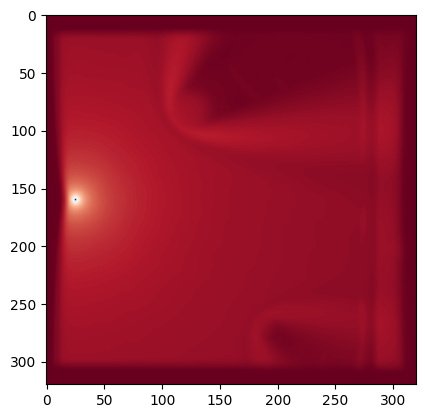

In [25]:
# Max pressure
plt.imshow(jnp.max(pressure_combined_raw, axis=0), aspect=None, cmap="RdBu")

In [26]:
import jax.numpy as jnp

In [27]:
pressure_data_hdr = pressure_combined_raw

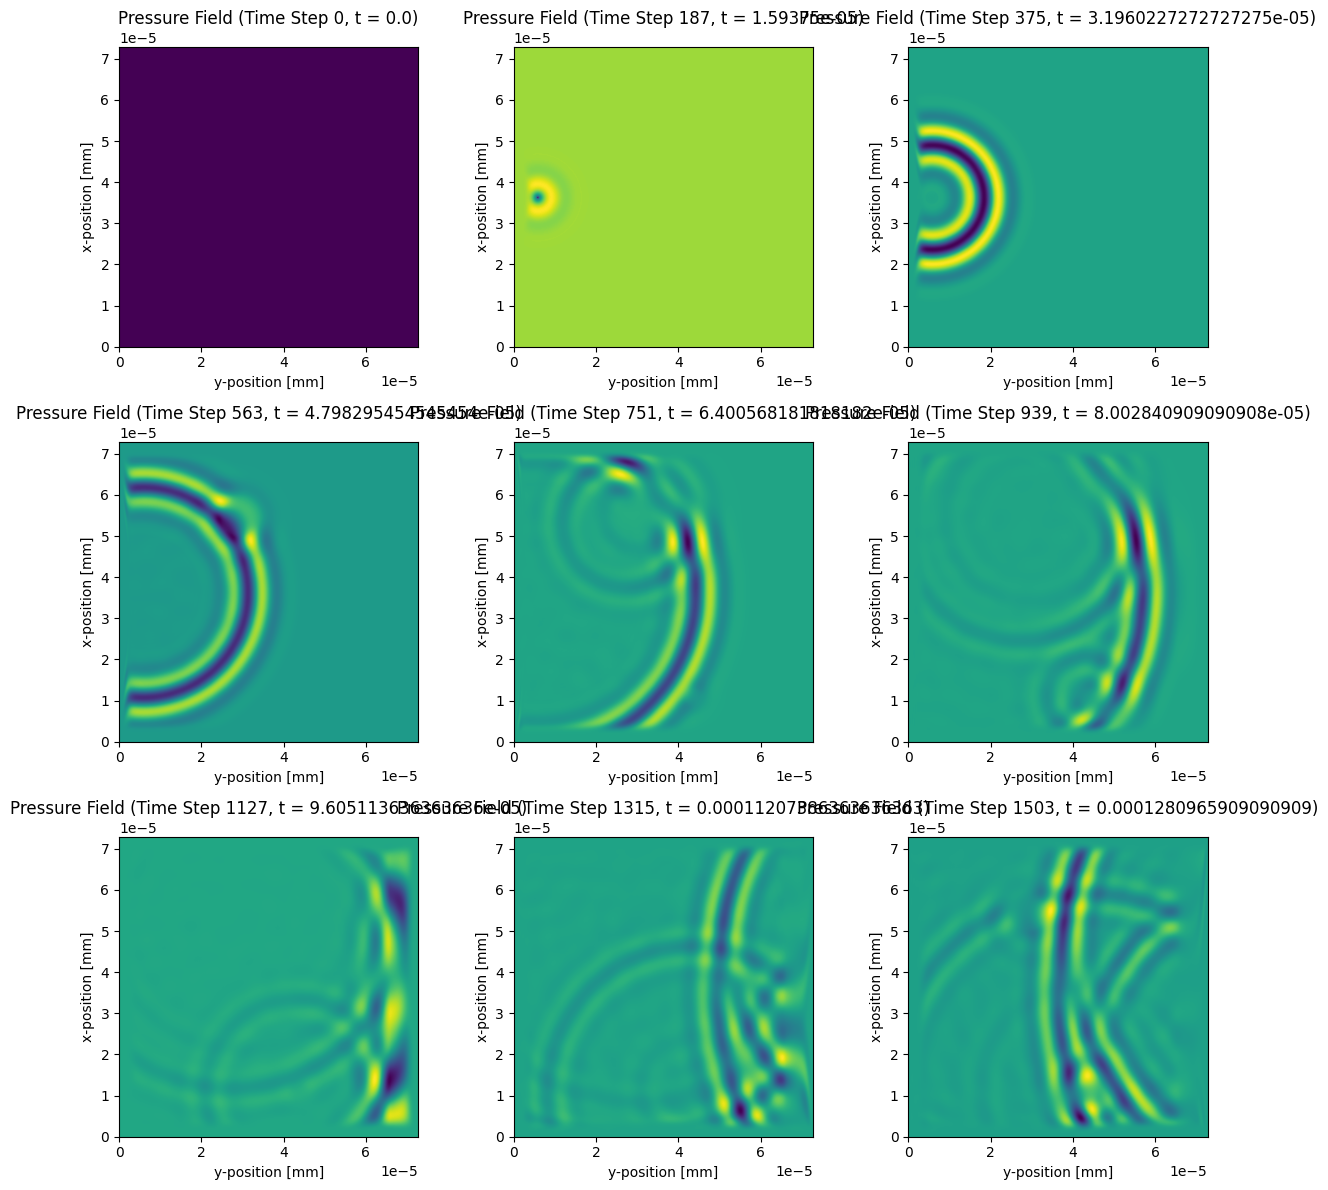

In [28]:
from jwave.experimental import plotting

plotting.plot_pressure_fields(pressure_data=pressure_data_hdr, domain_size=domain.size, time_axis_dt=time_axis.dt)

In [29]:
pressure_combined = FourierSeries(pressure_combined_raw, domain)

In [30]:
from jwave.extras.export import save_video

save_video(pressure_combined, './output.mp4', vmax=0.05, vmin=-0.05, fps=50)

100%|██████████| 1504/1504 [00:07<00:00, 213.01it/s]


In [31]:
pressure_combined.on_grid.shape

(1504, 320, 320, 1)

In [32]:
# pressure_raw = np.squeeze(pressure_combined)

In [33]:
# plotting.create_pressure_animation(pressure_data=pressure_data_hdr, domain_size=domain.size, dt=time_axis.dt)

In [34]:
# stop

# Tranducer array

Instead of a point source, we create a `TransducerArray` for the source and the sensor.

In [35]:
import importlib
import jwave
importlib.reload(jwave)
importlib.reload(jwave.geometry)

<module 'jwave.geometry' from '/opt/conda/lib/python3.10/site-packages/jwave/geometry.py'>

In [36]:
from jwave.geometry import TransducerArray

element_width_in_samples = 6
element_spacing_in_samples = 1
transducer_array = TransducerArray(domain=domain,
                                   num_elements=domain.N[0]//(element_width_in_samples+element_spacing_in_samples),
                                   element_width=domain.dx[0]*element_width_in_samples,
                                   element_height=domain.dx[1]*2,
                                   element_spacing=domain.dx[0]*element_spacing_in_samples,
                                   position=(domain.N[0] // 2 * domain.dx[0], 25 * domain.dx[1]),
                                   signal=jnp.stack([padded_signal]),
                                   sound_speed=sound_speed_background,
                                   dt=time_axis.dt,
                                   focus_distance=circle_center[1] * domain.dx[1], # (domain.N[1] // 2) * domain.dx[1], # halfway in grid
                                   steering_angle=0
                                  )

In [37]:
transducer_array.num_elements

45

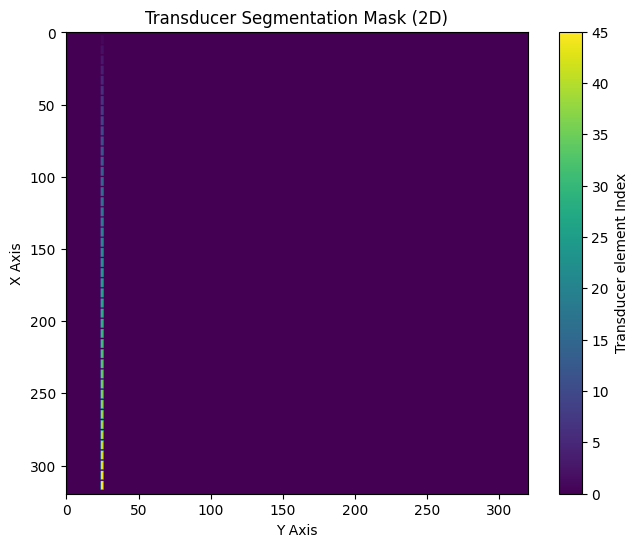

In [38]:
# Assuming transducer_array is an instance of TransducerArray with 2D domain
mask_2d = transducer_array.get_segmentation_mask()
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d, cmap='viridis')
plt.colorbar(label='Transducer element Index')
plt.title('Transducer Segmentation Mask (2D)')
plt.xlabel('Y Axis')
plt.ylabel('X Axis')
plt.show()

In [39]:
p0 = None

def get_sensor_data(sources, sensors):
    sound_speed_field=FourierSeries(np.expand_dims(sound_speed_map, -1), domain)
    density_field=FourierSeries(np.expand_dims(density_map, -1), domain)
    medium = Medium(domain=domain, sound_speed=sound_speed_field, density=density_field, pml_size=pml_size)
    return simulate_wave_propagation(
        medium, 
        time_axis, 
        p0=p0,
        sources=sources, 
        sensors=sensors
    )

transducer_array.set_active_elements(np.ones(transducer_array.num_elements))
sensor_data_onetime = get_sensor_data(sources=transducer_array, sensors=transducer_array)

In [40]:
sensor_data_onetime.shape

(1504, 45)

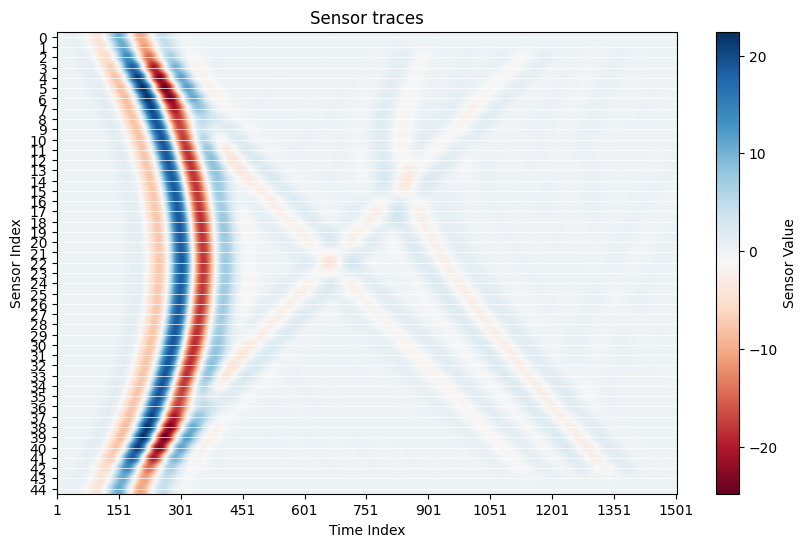

In [41]:
def plot_sensor_data(sensor_data):
    plt.figure(figsize=(10, 6))
    plt.imshow(jnp.expand_dims(sensor_data.T, -1), aspect="auto", cmap="RdBu")
    plt.title("Sensor traces")

    # Add x-axis labels
    plt.xticks(range(0, sensor_data.T.shape[1], round(sensor_data.T.shape[1]/10)), range(1, sensor_data.T.shape[1] + 1, round(sensor_data.T.shape[1]/10)))
    plt.xlabel("Time Index")

    # Add y-axis labels
    plt.yticks(range(0, sensor_data.T.shape[0]), range(0, sensor_data.T.shape[0]))
    plt.ylabel("Sensor Index")

    # Add grid lines
    plt.grid(which="major", axis="y", linestyle="-", linewidth=0.5, color="white")

    # Adjust tick positions
    plt.colorbar(label="Sensor Value")
    
plot_sensor_data(sensor_data_onetime)

In [42]:
# transducer_array.set_active_elements([False, False, False, False])
# transducer_array.elements[0].is_active = False
# transducer_array.elements[1].set_is_active(True)

# [element.is_active for element in transducer_array.elements]

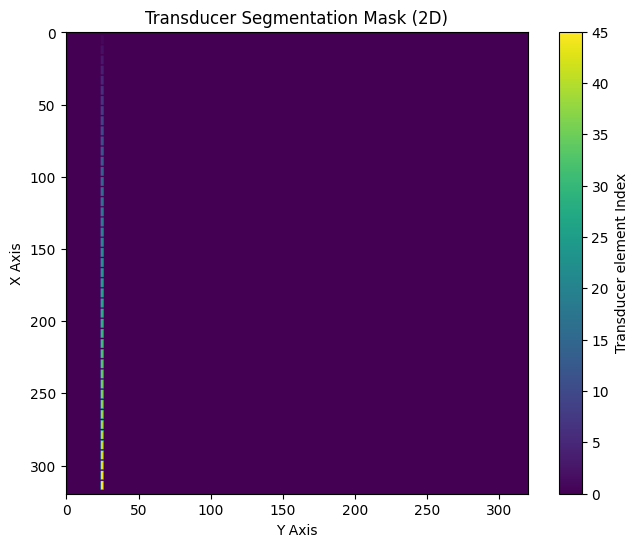

In [43]:
# Assuming transducer_array is an instance of TransducerArray with 2D domain
mask_2d = transducer_array.get_segmentation_mask()
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d, cmap='viridis')
plt.colorbar(label='Transducer element Index')
plt.title('Transducer Segmentation Mask (2D)')
plt.xlabel('Y Axis')
plt.ylabel('X Axis')

plt.show()

# Transducer max pressure test

In [44]:
focus_distance_y_per_scan = circle_center[1] * domain.dx[1]

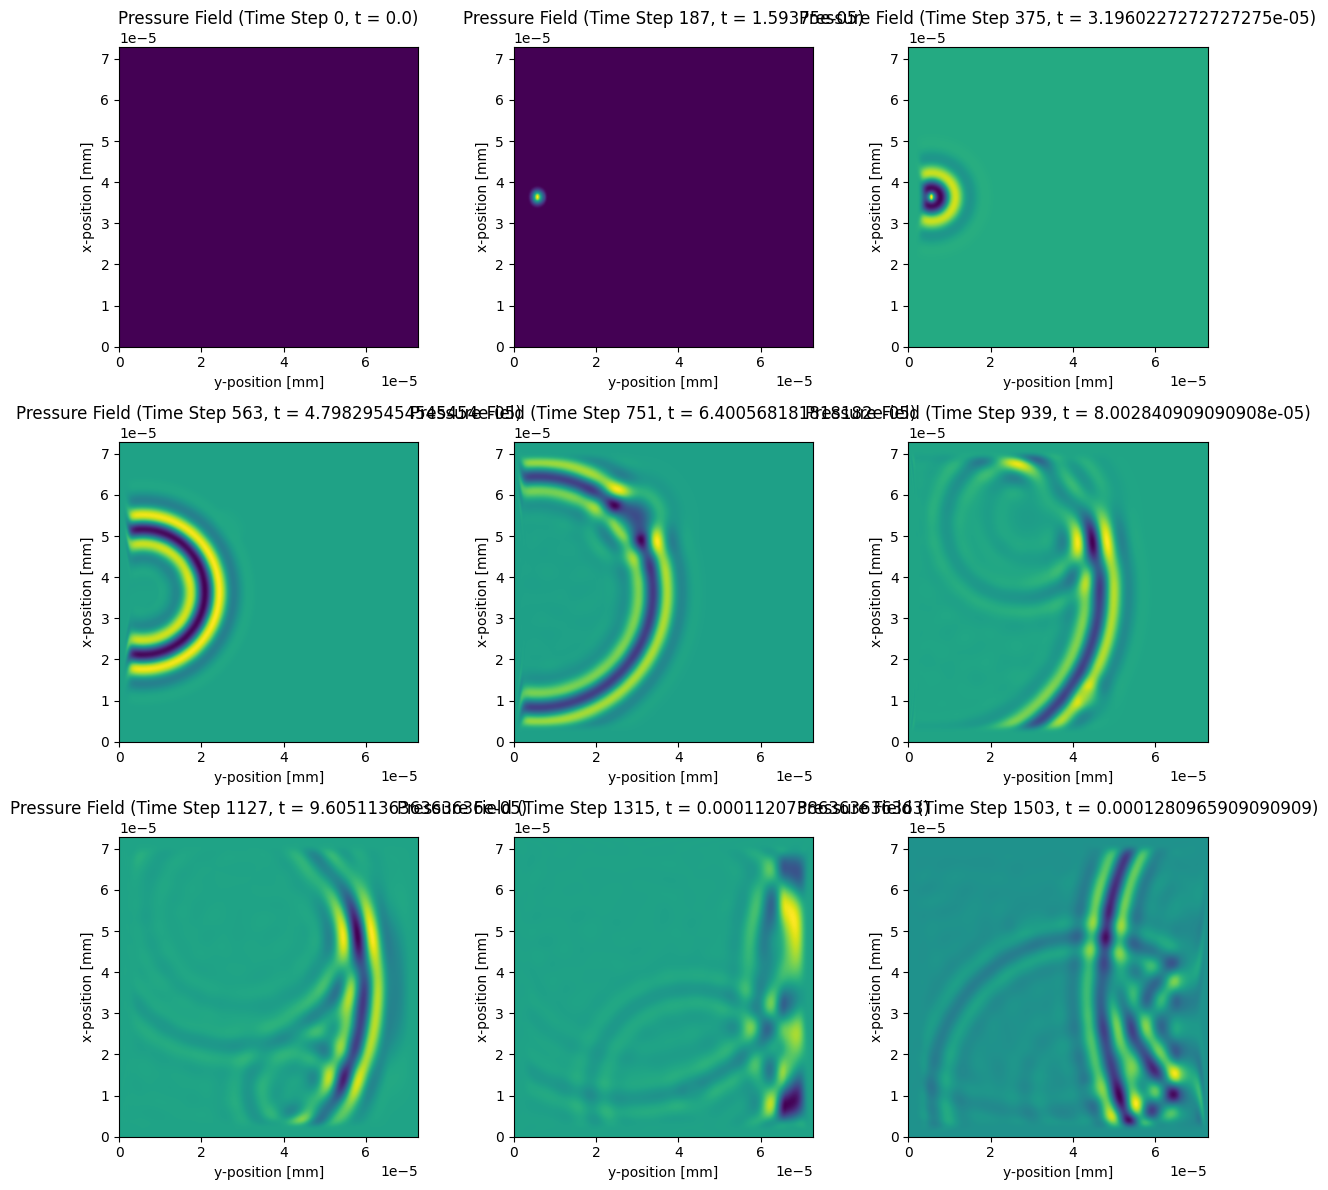

In [45]:
# Set the middle transducer on
idx = transducer_array.num_elements // 2
active_elements = np.zeros(transducer_array.num_elements)
active_elements[idx] = 1
middle_element_pos = transducer_array.elements[idx].center_pos

new_target_point = (middle_element_pos[0], middle_element_pos[1] + focus_distance_y_per_scan)
transducer_array.set_target_point(new_target_point)
# active_elements = np.ones(transducer_array.num_elements)

transducer_array.set_active_elements(active_elements)
sensor_data = get_sensor_data(sources=transducer_array, sensors=None)
plotting.plot_pressure_fields(pressure_data=sensor_data.on_grid, domain_size=domain.size, time_axis_dt=time_axis.dt)

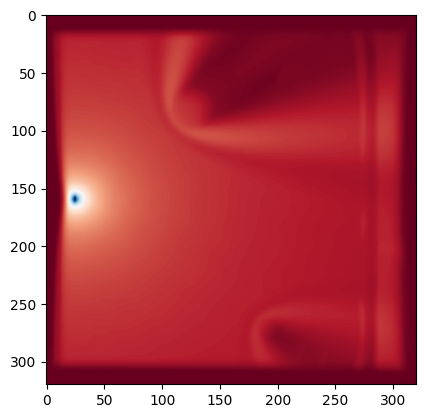

In [46]:
# Plot max sensor data
plt.imshow(jnp.max(sensor_data.on_grid, axis=0), aspect=None, cmap="RdBu")

In [47]:
from jwave.extras.export import save_video

save_video(sensor_data, './output_transducer.mp4', vmax=0.05, vmin=-0.05, fps=50)

100%|██████████| 1504/1504 [00:07<00:00, 210.70it/s]


# Create scan lines from first transducer element to the last

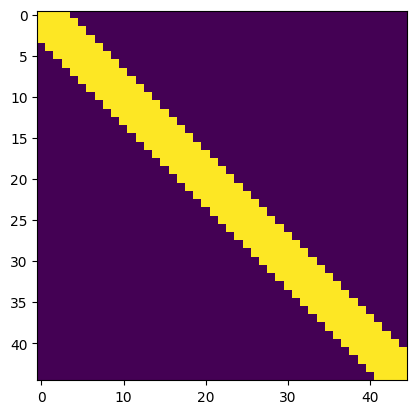

In [48]:
from jwave.experimental.transducer import generate_active_elements

# Range of steering angles to test
# steering_angles = np.arange(-32, 33, 2)
number_scan_lines = transducer_array.num_elements
WINDOW_SIZE = 7
active_elements = generate_active_elements(
    number_scan_lines=number_scan_lines, 
    transducer_number_elements=transducer_array.num_elements, 
    window_size=WINDOW_SIZE)

# Visualize active elements for each scan line
plt.imshow(active_elements)

## Generate scan lines: Method 1

I'm not sure how valid this is. This just offsets each sensor data with the delay during transmission.
However, that means that the reconstruction is only accurate at the focal point, since the offset is non-linear.

In [ ]:
from jwave.experimental import reconstruction
# def run_scan_lines(create_from_scratch):
scan_lines_simple = np.zeros((int(time_axis.Nt), number_scan_lines))
scan_lines_nobeamform = np.zeros((int(time_axis.Nt), transducer_array.num_elements, number_scan_lines,))

for scan_index in range(number_scan_lines):
    print(f'Computing scan line {scan_index+1} of {number_scan_lines}')

    # Update the current active elements
    transducer_array.set_active_elements(active_elements[scan_index])    

    # Update the target position
    active_elements_indices = np.nonzero(active_elements[scan_index])[0]    
    middle_active_element = active_elements_indices[len(active_elements_indices) // 2]

    # print(f"middle_active_element: {middle_active_element}")

    middle_element_pos = transducer_array.elements[middle_active_element].center_pos

    # print(f"middle_element_pos: {middle_element_pos}")

    new_target_point = (middle_element_pos[0], middle_element_pos[1] + focus_distance_y_per_scan)

    # print(f"new_target_point: {new_target_point}, focus_distance: {transducer_array.focus_distance}, steering_angle: {transducer_array.steering_angle}")

    transducer_array.set_target_point(new_target_point)    

    sensor_data = get_sensor_data(sources=transducer_array, sensors=transducer_array)

    # scan_lines_nobeamform[:, :, scan_index] = sensor_data
    scan_lines_nobeamform[:, active_elements[scan_index].astype(bool), scan_index] = sensor_data

    # scan_lines[:, scan_index] = transducer_array.scan_line(sensor_data) # [:int(time_axis.Nt)]
    scan_line = transducer_array.scan_line(sensor_data)

    scan_line_trimmed = reconstruction.trim_scan_lines(
        scan_lines=jnp.expand_dims(scan_line, -1),
        input_signal=source_signal,
        max_delay_in_samples=transducer_array.max_delay_in_samples
    ).squeeze()

    # plt.plot(scan_line[transducer_array.max_delay_in_samples:])
    # scan_lines[:, scan_index] = scan_line[transducer_array.max_delay_in_samples:]
    scan_lines_simple[:, scan_index] = scan_line_trimmed
    # print(f"scan_line.shape: {scan_line.shape}")
    # print(f"scan_line_trimmed.shape: {scan_line_trimmed.shape}")
    # print(transducer_array.max_delay_in_samples)

        # return scan_lines

Computing scan line 1 of 45
Computing scan line 2 of 45
Computing scan line 3 of 45
Computing scan line 4 of 45
Computing scan line 5 of 45
Computing scan line 6 of 45
Computing scan line 7 of 45
Computing scan line 8 of 45
Computing scan line 9 of 45
Computing scan line 10 of 45
Computing scan line 11 of 45
Computing scan line 12 of 45
Computing scan line 13 of 45
Computing scan line 14 of 45
Computing scan line 15 of 45
Computing scan line 16 of 45
Computing scan line 17 of 45
Computing scan line 18 of 45
Computing scan line 19 of 45
Computing scan line 20 of 45
Computing scan line 21 of 45
Computing scan line 22 of 45
Computing scan line 23 of 45
Computing scan line 24 of 45
Computing scan line 25 of 45


In [ ]:
ax = plot_sensor_data(scan_lines_simple)

# Sense-making scan-line algorithm that takes depth into account properly

This slower approaches calculates the time delay for each reconstruction pixel (x and y) and picks the closest index in the data corresponding to it.

In [ ]:
# plt.imshow(sensor_data.T[:, :210], aspect="auto", cmap="RdBu")

scan_lines = np.zeros((int(time_axis.Nt), number_scan_lines))

beamform_indices_all = []

for scan_index in range(0, number_scan_lines):
    print(f'Computing scan line {scan_index+1} of {number_scan_lines}')
    transducer_array.set_active_elements(active_elements[scan_index])    

    # Update the target position
    active_elements_indices = np.nonzero(active_elements[scan_index])[0]    
    middle_active_element = active_elements_indices[len(active_elements_indices) // 2]

    middle_element_pos = transducer_array.elements[middle_active_element].center_pos

    new_target_point = (middle_element_pos[0], middle_element_pos[1] + domain.N[1]*domain.dx[1])

    transducer_array.set_target_point(new_target_point)    

    # print(new_target_point)

    sensor_data = get_sensor_data(sources=transducer_array, sensors=transducer_array)

    num_active_elements = np.sum(active_elements[scan_index])
    num_time_samples = sensor_data.shape[0]

    beamform_indices = np.zeros((num_time_samples, num_active_elements))

    delays_in_samples_middle = jnp.round(
        TransducerArray.calculate_beamforming_delays(
            source_positions=jnp.array([middle_element_pos]),
            target_point=transducer_array.target_point,
            sound_speed=transducer_array.sound_speed,
            max_delay=transducer_array.max_delay
        ) / transducer_array.dt)[0]
    print(f"delays_in_samples_middle: {delays_in_samples_middle}")

    for depth_idx in range(0, num_time_samples):
        # print(f'\tComputing depth line {depth_idx+1} of {num_time_samples}')
        
        # middle_element_pos = transducer_array.elements[middle_active_element].center_pos

        scan_target_point = (middle_element_pos[0], middle_element_pos[1] + depth_idx*sound_speed_background*time_axis.dt)

        # Get active sensors
        active_sensor_positions = np.array([element.center_pos for element in transducer_array.elements if element.is_active])

        # Find distance from each sensor to the new target point
        distances = jnp.sqrt(((active_sensor_positions[:, 0] - scan_target_point[0])**2) +
                             ((active_sensor_positions[:, 1] - scan_target_point[1])**2))

        # Calculate sound wave travel times
        round_trip_time = distances / sound_speed_background 

        round_trip_time_in_samples = (round(round_trip_time / time_axis.dt))

        beamform_indices[depth_idx, :] = round_trip_time_in_samples + delays_in_samples_middle

    # Fix formats
    sensor_data = np.array(sensor_data)
    beamform_indices = beamform_indices.astype(int)
    beamform_indices_all.append(beamform_indices)

    valid_indices = np.clip(beamform_indices, 0, sensor_data.shape[0] - 1)
    scan_line = np.sum(sensor_data[valid_indices, np.arange(sensor_data.shape[1])], axis=1)
    
    # scan_line_trimmed = reconstruction.trim_scan_lines(
    #     scan_lines=jnp.expand_dims(scan_line, -1),
    #     input_signal=source_signal,
    #     max_delay_in_samples=transducer_array.max_delay_in_samples
    # ).squeeze()    

    # print(transducer_array.max_delay_in_samples, scan_line.shape, scan_line.shape-)
    # print(scan_line_trimmed.shape)
    scan_lines[:, scan_index] = scan_line
    

        # print(round_trip_time_in_samples)

        # delay = delays_in_samples[i]
        # plt.axvline(x=delay, ymin=(i)/num_sensors, ymax=(i+1)/num_sensors, linestyle='--', alpha=0.7)
        # print(delay)

In [ ]:
ax = plot_sensor_data(scan_lines[len(source_signal):, :])

In [ ]:
# Compare with "simple" version
ax = plot_sensor_data(scan_lines_simple)

You can see that the relationship between each depth and beamform index is not the same, and certainly not guaranteed to be linear.

The middle element in a scan line would be linear though as the depth line is positioned relative to it.

In [ ]:
# Number of plots equals the number of series
num_plots = beamform_indices_middle_element.shape[1]

# Define the grid size as close to square as possible
rows = int(np.ceil(np.sqrt(num_plots)))
cols = int(np.ceil(num_plots / rows))

# Creating subplots in a grid
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust size as needed
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

for i in range(num_plots):
    for j in range(num_plots):
        line_color = 'grey' if i != j else 'blue'
        line_alpha = 0.3 if i != j else 1.0
        line_width = 1 if i != j else 2
        axs[i].plot(beamform_indices_middle_element[:100, j], label=f'Index {j+1}' if i == j else None, 
                    color=line_color, alpha=line_alpha, linewidth=line_width)
    
    axs[i].legend(loc='upper right')
    axs[i].set_title(f'Index {i+1}')
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel('Value')

# Disable unused axes if any
for ax in axs[num_plots:]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Trim signal from scan lines

In [ ]:
scan_lines_trimmed = scan_lines[round(len(source_signal)*1.2):, :]

scan_lines_trimmed.shape

In [ ]:
# Combine elements per scan line

In [ ]:
focus_distance_y_per_scan

In [ ]:
distance_y_in_m = domain.N[1] * domain.dx[1]

grid_edge_in_samples = distance_y_in_m / transducer_array.sound_speed / transducer_array.dt

In [ ]:
transducer_array.dt

In [ ]:
ax = plot_sensor_data(scan_lines)

In [ ]:
ax = plot_sensor_data(scan_lines_trimmed)

source_end_in_samples = int(len(source_signal))
plt.axvline(x=source_end_in_samples, color='cyan', linestyle='-', linewidth=1.5)

focus_depth_in_samples = focus_distance_y_per_scan * 2 / transducer_array.sound_speed / transducer_array.dt

# plt.axvline(x=grid_edge_in_samples, color='g', linestyle='-', linewidth=1.5)
plt.axvline(x=grid_edge_in_samples*2, color='g', linestyle='-', linewidth=1.5)

plt.axvline(x=focus_depth_in_samples + source_end_in_samples, color='magenta', linestyle='-', linewidth=1.5)

In [ ]:
plot_sensor_data(scan_lines_trimmed)

In [ ]:
plot_sensor_data(sensor_data_onetime)

# Post process sensor data

In [ ]:
from kwave.utils.filters import gaussian_filter

scan_lines_fund = gaussian_filter(scan_lines_trimmed.T, 1/time_axis.dt, source_frequency, 100)
scan_lines_harm = gaussian_filter(scan_lines_trimmed.T, 1/time_axis.dt, 2 * source_frequency, 30)

In [ ]:
from kwave.reconstruction.beamform import envelope_detection

scan_lines_fund = envelope_detection(scan_lines_fund)
scan_lines_harm = envelope_detection(scan_lines_harm)

In [ ]:
from kwave.reconstruction.tools import log_compression

compression_ratio = 3
scan_lines_fund = log_compression(scan_lines_fund, compression_ratio, True)
scan_lines_harm = log_compression(scan_lines_harm, compression_ratio, True)

In [ ]:
scan_lines_fund.shape

In [ ]:
def x_extents(self) -> Tuple[float, float]:
    return float(self.elements[0].center_pos[0]), float(self.elements[-1].center_pos[0])

x_extents(transducer_array)

In [ ]:
# image_size = [domain.N[0] * domain.dx[0], domain.N[1] * domain.dx[1]]

# Create the axis variables
x_axis = transducer_array.x_extents()
y_axis = [0, domain.N[1] * domain.dx[1]]
max_y_samples = int(domain.N[1]*domain.dx[1] / transducer_array.sound_speed / time_axis.dt)

scan_lines_fund = scan_lines_fund[:, :max_y_samples*2]

In [ ]:
scan_lines_fund.shape[1] * time_axis.dt/2

In [ ]:
scan_lines_fund.shape[1]*time_axis.dt * transducer_array.sound_speed

In [ ]:
# Calculate the extent to properly map the axes
extent = [y_axis[0], scan_lines_fund.shape[1]*time_axis.dt * transducer_array.sound_speed, x_axis[0], x_axis[1]]

print(extent)

aspect_ratio = (extent[1] - extent[0])/(extent[3] - extent[2])

In [ ]:
np.array(domain.N) * np.array(domain.dx)

In [ ]:

plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
plt.subplot(132)
plt.imshow(scan_lines_fund,
           # aspect=aspect_ratio,
           extent=extent,
           interpolation='none', 
           cmap='bone')
plt.xlabel('Depth [m]')
plt.ylabel('x [m]')
plt.title('Processed Scan-Line Data')
# plt.colorbar(label='Intensity')  # Add a color bar for better understanding of the plot scale

plt.show()

In [ ]:
show_positive_field(sound_speed_map, aspect=None)
_ = plt.title("sound_speed")